# Анализ оттока клиентов для Метанпромбанк

**Задача:**
Проанализировать клиентов регионального банка и выделить сегменты, которые склонны уходить из банка. Сформировать рекомендации для снижения оттока.

## Декомпозиция 

**1. Загрузка, ознакомление с данными.**

    загрузка
    вывод информации о датафрейме
    вывод по шагу 1

**2. Предварительная обработка.**
    
    корректировка наименования столбцов
    проверка и обработка явных, неявных дубликатов
    классификация, выяснение причин пропусков, их заполнение/удаление (при возможности и необходимости)
    кодирование категориальных данных
    вывод по шагу 2

**3. Исследовательский анализ данных (EDA).**

    разделение параметров на непрерывные и категориальные/дискретные
    анализ распределения признаков в разрезе оттока (построим визуализации)
    определим портрет клиентов в разрезе оттока
    корреляционный анализ признака churn
    вывод по шагу  3

**4. Проверка статистических гипотез.**

    проверим гипотезу равенства доходов клиентов, которые ушли, и тех, что остались
    другие гипотезы буду сформулированы в ходе работы над проектом
    вывод по шагу 4

**5. Подведение промежуточных итогов.**

    резюме по результатам EDA, корреляционного анализа, проверки гипотез
    выделение признаков, влияющих на отток

**6. Сегментация.**

    выделим не менее 3 сегментов, от 500 клиентов на каждый, отток в сегменте выше среднего по банку

**7. Приоритизация сегментов.**

**8. Формирование таргетированных рекомендаций.**

**Описание данных.**

Датасет содержит данные о клиентах Метанпромбанка. Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск:

    USERID — идентификатор пользователя,
    score — баллы кредитного скоринга,
    city — город,
    gender — пол,
    age — возраст,
    equity — количество баллов собственности
    balance — баланс на счёте,
    products — количество продуктов, которыми пользуется клиент,
    credit_card — есть ли кредитная карта,
    last_activity — активный клиент,
    EST_SALARY — оценочный доход клиента,
    сhurn — признак оттока.

In [1]:
!pip install missingno

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='darkgrid', font='sans-serif', font_scale=1, color_codes=False, rc=None)
import numpy as np
from scipy import stats as st
import math as mth
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

## Загрузка, ознакомление с данными

In [3]:
data = pd.read_csv('...') 

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


Данные содержат 10 000 записей о клиентах банка. 

При этом имеются пропуски в age, balance. 

На стадии предварительной обработки необходимо привести наименование столбцов к нижнему регистру, проверить и обработать дубликаты, классифицировать, выяснить причины и провести обработку пропусков.

## Предварительная обработка данных

**Скорректировал наименование столбцов.**

In [5]:
data.columns = data.columns.str.lower()
data.rename(columns={'userid': 'user_id'}, inplace=True)

**Проверил наличие дубликатов.**

In [6]:
print('Количество явных дубликатов:', data.duplicated().sum(), '\n'
      'Количество дубликатов по user_id:', data['user_id'].duplicated().sum())

Количество явных дубликатов: 0 
Количество дубликатов по user_id: 73


In [7]:
data[data['user_id'].duplicated(keep=False)].sort_values('user_id') 

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2597,226719,990.0,Ярославль,М,37.0,4,14648692.14,2,0,0,934412.61,1
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0
6457,228075,839.0,Рыбинск,М,39.0,5,507199.85,3,0,1,85195.80,0


В строках с аналогичным user_id клиенты с разными параметрами (то есть это разные клиенты), при этом, если обратить внимание на churn, можно сделать вывод, что новым клиентам присваивается user_id ушедших. С учетом этого оснований для удаления строк с одинаковым user_id нет.

Удалим признак user_id.

In [8]:
data.drop(columns='user_id', inplace=True)

**Классификация, выяснение причин и обработка пропусков (age, balance).**

In [9]:
print('Пропусков в age:', (data.age.isna().sum() / len(data)).round(4) * 100, '%', '\n'
      'Пропусков в balance:', (data.balance.isna().sum() / len(data)).round(4) * 100, '%')

Пропусков в age: 0.26 % 
Пропусков в balance: 22.95 %


Построим матрицу пропущенных значений.

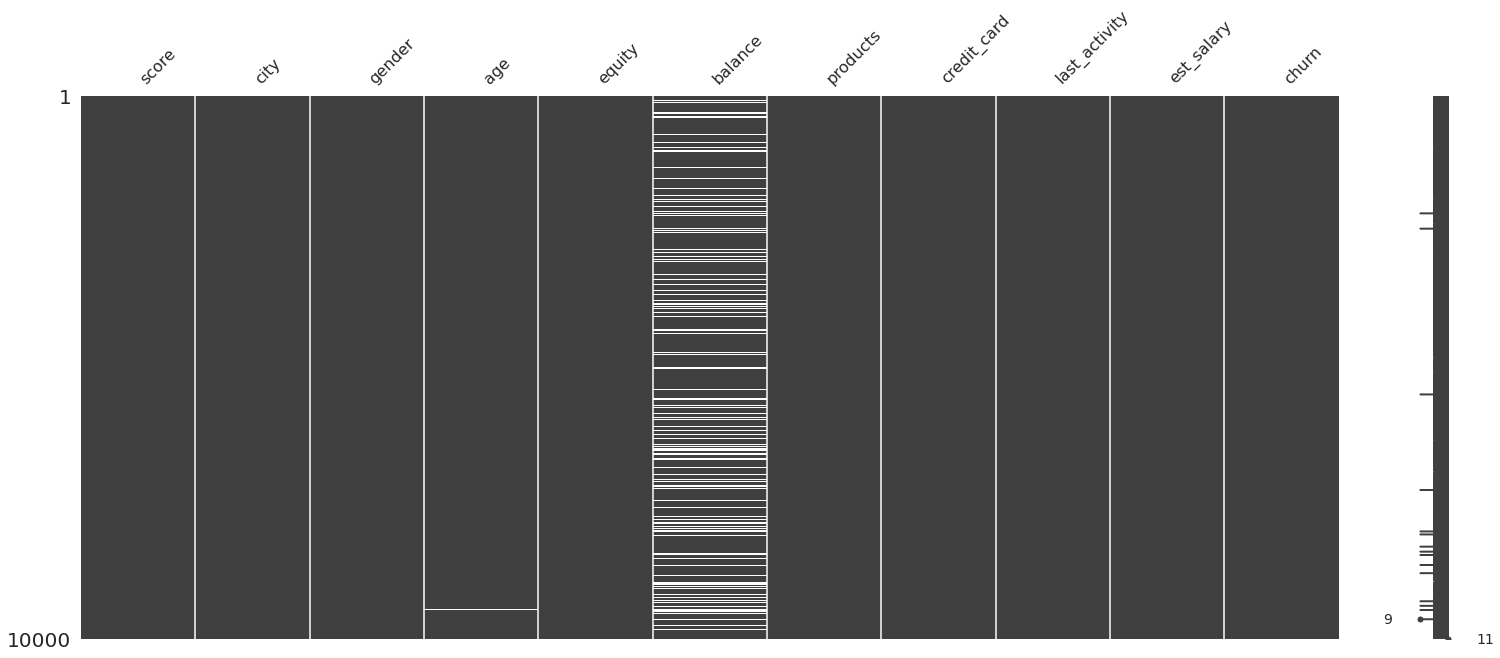

In [10]:
msno.matrix(data);

In [11]:
print('Количество клиентов с пропуском в age:', len(data[data['age'].isna()]), '\n'
      'Количество отточных клиентов с пропуском в age:', len(data[data['age'].isna()].query('churn == 1')))

Количество клиентов с пропуском в age: 26 
Количество отточных клиентов с пропуском в age: 1


Имеется незначительное количество строк с пропуском в age, из них всего 1 отточный клиент.

In [12]:
data[data.age.isna()]

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
2165,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2444,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
3091,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
5470,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0
5495,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0
7236,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0
7248,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0
7345,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0


In [13]:
data['missed_age'] = data['age'].isna() * 1

Введем столбец с признаком 1 (пропущено)/0 (не пропущено) для пропусков значений в balance.

In [14]:
data['missed_balance'] = data['balance'].isna() * 1
data.query('missed_balance == 1').head()

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_age,missed_balance
2,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1
9,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,0,1
10,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0,0,1
11,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0,0,1
19,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0,0,1


**Кодирование категориальных неупорядоченных признаков (city, gender).**

In [15]:
data_dumm = data.copy()
data_dumm['city_name'] = data_dumm['city']
data_dumm['gender_sign'] = data_dumm['gender']

data_dumm = pd.get_dummies(data_dumm, columns=['city', 'gender'])
data_dumm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   score           10000 non-null  float64
 1   age             9974 non-null   float64
 2   equity          10000 non-null  int64  
 3   balance         7705 non-null   float64
 4   products        10000 non-null  int64  
 5   credit_card     10000 non-null  int64  
 6   last_activity   10000 non-null  int64  
 7   est_salary      10000 non-null  float64
 8   churn           10000 non-null  int64  
 9   missed_age      10000 non-null  int64  
 10  missed_balance  10000 non-null  int64  
 11  city_name       10000 non-null  object 
 12  gender_sign     10000 non-null  object 
 13  city_Ростов     10000 non-null  uint8  
 14  city_Рыбинск    10000 non-null  uint8  
 15  city_Ярославль  10000 non-null  uint8  
 16  gender_Ж        10000 non-null  uint8  
 17  gender_М        10000 non-null  

Выведем матрицу корреляции.

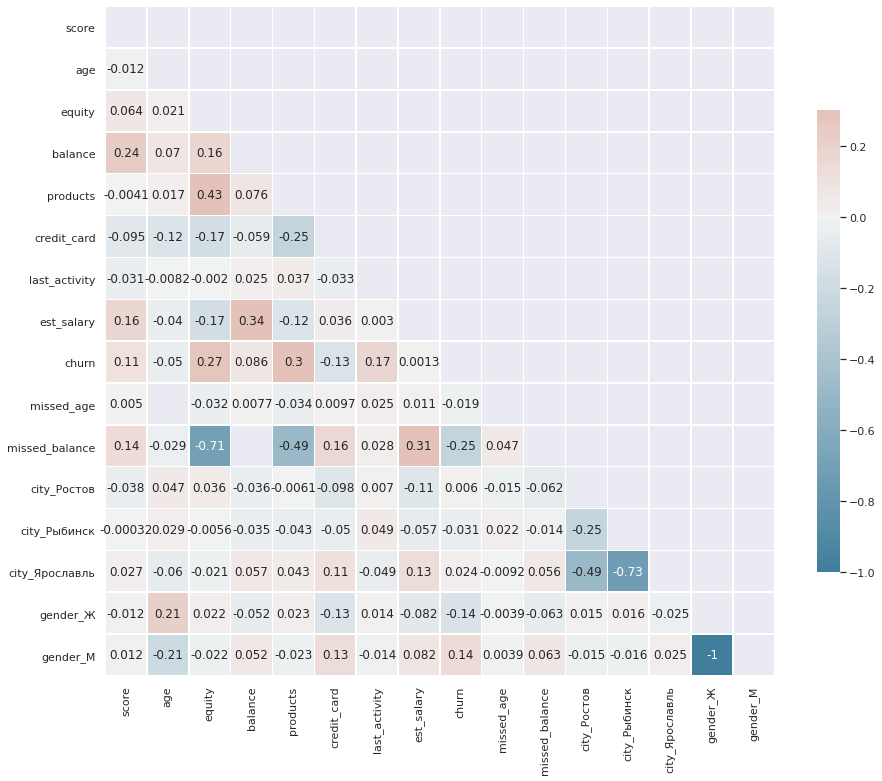

In [16]:
mask = np.triu(np.ones_like(data_dumm.corr(), dtype=bool))

f, ax = plt.subplots(figsize=(15, 17))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(data_dumm.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, annot = True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Закономерностей в пропусках age не усматривается, можно классифицировать их как MCAR (Missing Completely At Random / Отсутствует совершенно случайно) — пропуски не зависят от переменных и не ведут к систематической ошибке (смещение, bias), но увеличивают случайную ошибку (разброс, variance), можно их отбрасывать или заполнять, т.к. заполнение не повлияет на характер связи между заполняемой переменной и остальными. Удалю пропуски в age.

Можно отметить зависимость missed_balance и признаками equity (высокая), products (умеренная), est_salary (умеренная). 

Таким образом, пропуски в balance классифицируются как MNAR (Missing Not At Random / отсутствует не случайно) — пропуски зависят от данных, без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, так как это приведёт к заметным искажениям.

In [17]:
data.dropna(subset=['age'], inplace=True)
data_dumm.dropna(subset=['age'], inplace=True)

**Кодирование категориальных неупорядоченных признаков (city, gender).**

На шаге 3 скорректированы наименования столбцов.

Установлено, что явных дубликатов нет. Количество неявных дубликатов по признаку user_id 73. В строках с аналогичным user_id записаны клиенты с разными параметрами (то есть это разные клиенты), при этом, если обратить внимание на churn, можно сделать вывод, что новым клиентам присваивается user_id ушедших. С учетом этого оснований для удаления строк с одинаковым user_id нет. Признак user_id удален, поскольку не нужен для дальнейшей работы.

Имеются пропуски в age (0,26% и 26), balance (22,95% и 2295). С учетом незначительного количества пропусков в age - оставил пропуски. Можно отметить зависимость пропущенных значений в balance и признаками equity (сильная), products, est_salary. Таким образом, пропуски в balance классифицируются как MNAR (Missing Not At Random / отсутствует не случайно) — пропуски зависят от данных, без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, так как это приведёт к заметным искажениям. Оставил пропуски в balance.

Кодировал категориальные неупорядоченные признаки (city, gender) при помощи функции pd.get_dummies() для дальнейшей работы с корреляцией.

P.S. Далее на стадии EDA при построении графиков обнаружился клиент без единого продукта, который попал в отток. Так же отсутствует кредитная карта, нет активности. Можно удалить строку, чтобы исключить влияние на исследование. Мне кажется, что эта запись подвисла в период разрешения юридических вопросов в рамках наследственного дела. Если так, то по понятным причинам ценности для исследования оттока она не имеет. 

In [18]:
data.query('products == 0')

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_age,missed_balance
8957,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1,0,1


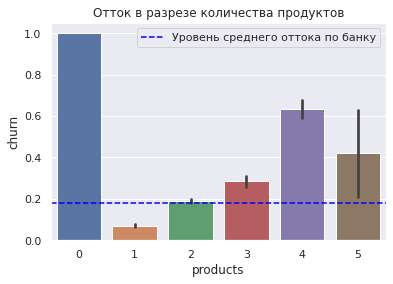

In [19]:
sns.barplot(data=data, x='products', y='churn').set(title='Отток в разрезе количества продуктов')
plt.axhline(y=data.churn.mean(), color='blue', linestyle='--', label ='Уровень среднего оттока по банку')
plt.legend(loc ='upper right')
plt.show()

In [20]:
data = data.loc[data['products'] != 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9973 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   score           9973 non-null   float64
 1   city            9973 non-null   object 
 2   gender          9973 non-null   object 
 3   age             9973 non-null   float64
 4   equity          9973 non-null   int64  
 5   balance         7695 non-null   float64
 6   products        9973 non-null   int64  
 7   credit_card     9973 non-null   int64  
 8   last_activity   9973 non-null   int64  
 9   est_salary      9973 non-null   float64
 10  churn           9973 non-null   int64  
 11  missed_age      9973 non-null   int64  
 12  missed_balance  9973 non-null   int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 1.1+ MB


## Исследовательский анализ данных (EDA)

**Разделение и анализ непрерывных (score, age, balance, est_salary) и дискретных признаков (city, gender, equity, products, credit_card, last_activity).**

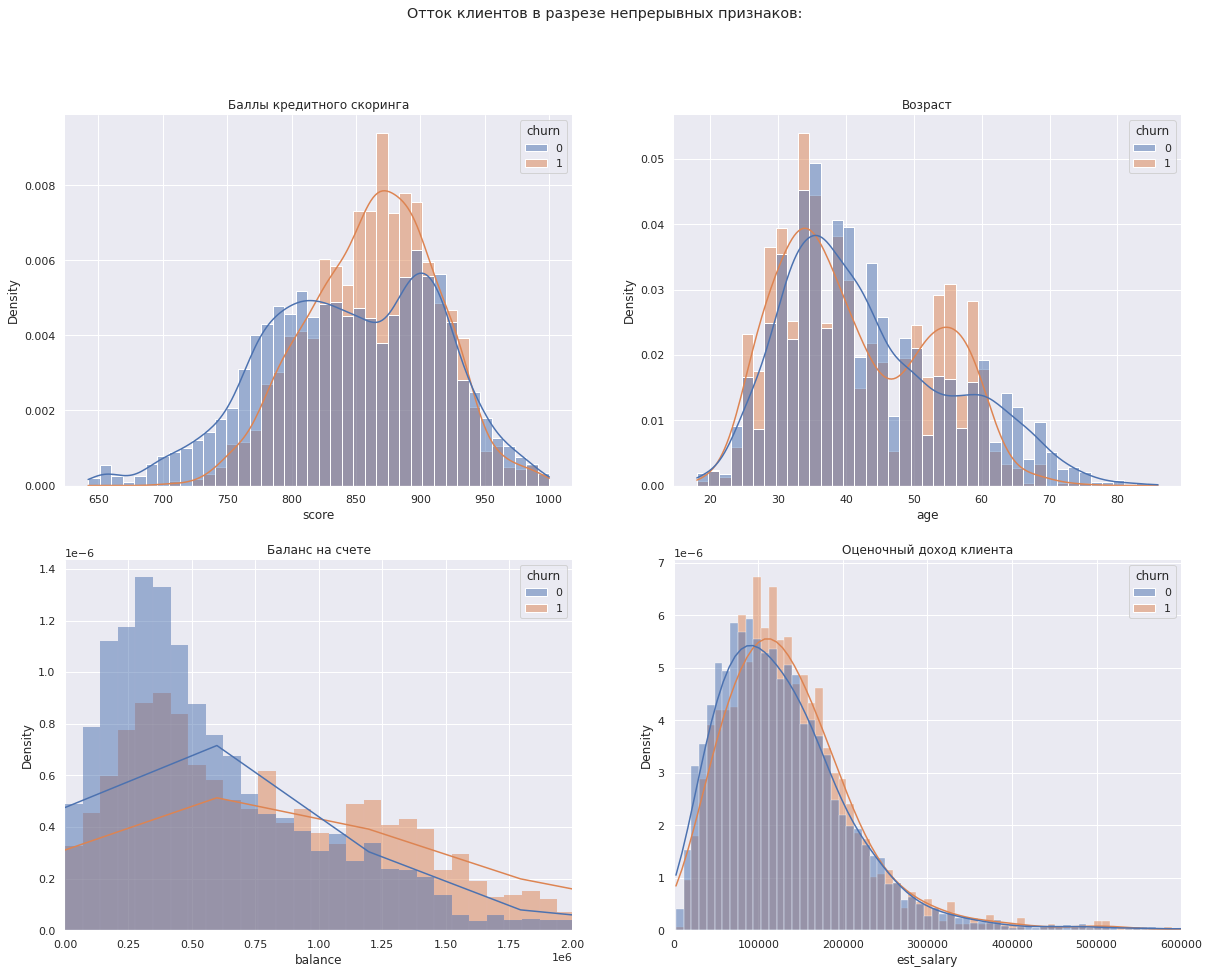

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.despine(left=True)

sns.histplot(data=data, hue='churn', x='score', stat='density', common_norm=False, kde=True, ax=axes[0, 0])
sns.histplot(data=data, hue='churn', x='age', stat='density', common_norm=False, kde=True, ax=axes[0, 1])
sns.histplot(data=data, hue='churn', x='balance', stat='density', common_norm=False, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlim(0, 2000000)
sns.histplot(data=data, hue='churn', x='est_salary', stat='density', common_norm=False, kde=True, ax=axes[1, 1])
axes[1, 1].set_xlim(0, 600000)

axes[0, 0].set_title('Баллы кредитного скоринга')
axes[0, 1].set_title('Возраст')
axes[1, 0].set_title('Баланс на счете')
axes[1, 1].set_title('Оценочный доход клиента')

fig.suptitle('Отток клиентов в разрезе непрерывных признаков:')
fig.show()

Отток выше лояльности в интервалах:

    баллов скоринга 820-940, 
    возраста 26-36 и 51-61, 
    баланса на счет от 1 млн., 
    уровня доходов 100 - 250 тыс.

In [22]:
print('Доля оттока по банку:', data.churn.mean())

Доля оттока по банку: 0.18229218891005716


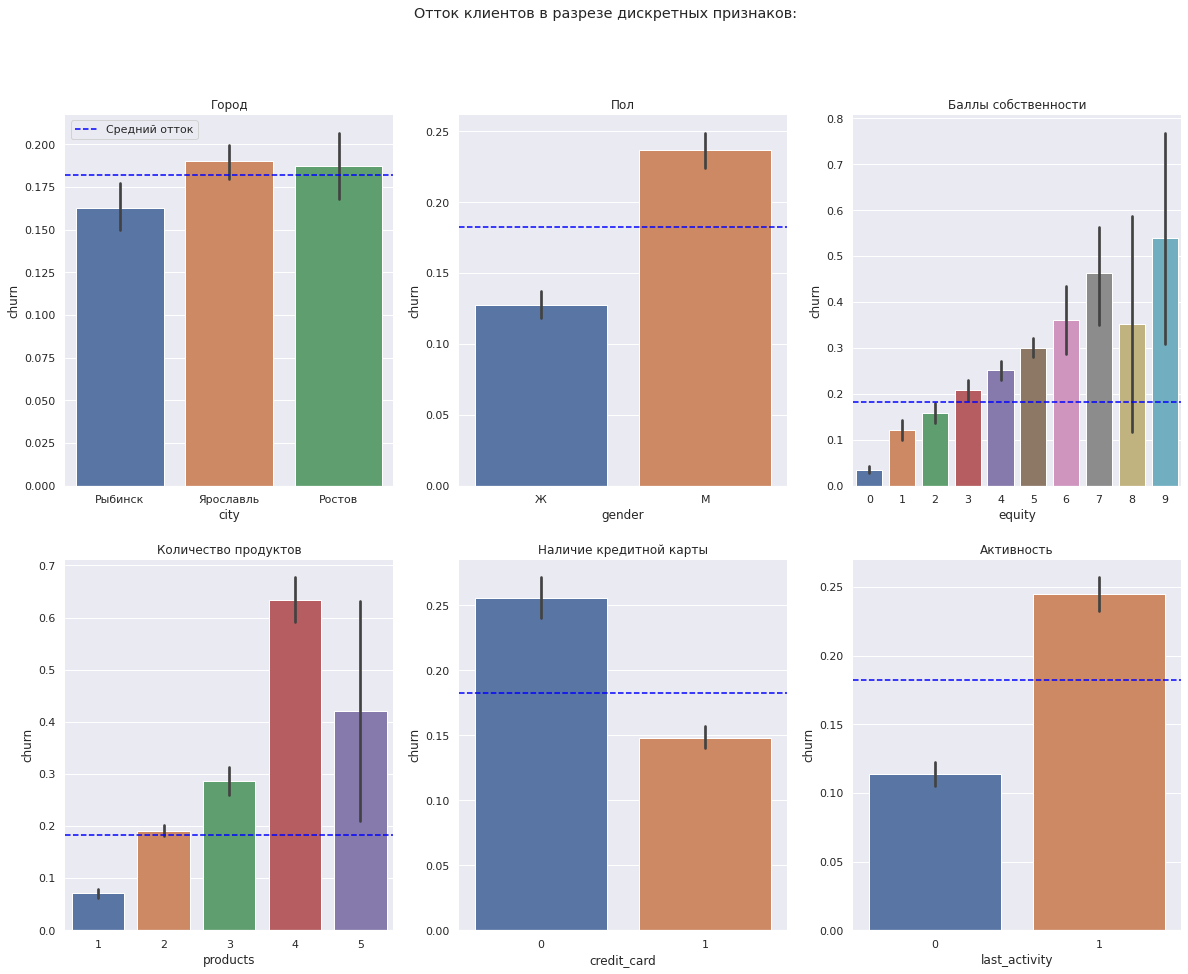

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
sns.despine(left=True)

sns.barplot(data=data, x='city', y='churn', ax=axes[0, 0])
axes[0, 0].axhline(y=data.churn.mean(), color='blue', linestyle='--', label ='Средний отток')
sns.barplot(data=data, x='gender', y='churn', ax=axes[0, 1])
axes[0, 1].axhline(y=data.churn.mean(), color='blue', linestyle='--', label ='Средний отток')
sns.barplot(data=data, x='equity', y='churn', ax=axes[0, 2])
axes[0, 2].axhline(y=data.churn.mean(), color='blue', linestyle='--', label ='Средний отток')
sns.barplot(data=data, x='products', y='churn', ax=axes[1, 0])
axes[1, 0].axhline(y=data.churn.mean(), color='blue', linestyle='--', label ='Средний отток')
sns.barplot(data=data, x='credit_card', y='churn', ax=axes[1, 1])
axes[1, 1].axhline(y=data.churn.mean(), color='blue', linestyle='--', label ='Средний отток')
sns.barplot(data=data, x='last_activity', y='churn', ax=axes[1, 2])
axes[1, 2].axhline(y=data.churn.mean(), color='blue', linestyle='--', label ='Средний отток')

axes[0, 0].set_title('Город')
axes[0, 1].set_title('Пол')
axes[0, 2].set_title('Баллы собственности')
axes[1, 0].set_title('Количество продуктов')
axes[1, 1].set_title('Наличие кредитной карты')
axes[1, 2].set_title('Активность')

axes[0, 0].legend(loc ='upper left')
fig.suptitle('Отток клиентов в разрезе дискретных признаков:')

fig.show()

Уровень оттока выше среднего по банку:

    в Ярославле и Рыбинске,
    среди мужчин,
    от 3 до 9 баллов собственности,
    от 3 до 5 продуктов,
    не имеющих кредитной карты,
    среди активных клиентов

**Корреляционный анализ.**

Удалил признаки missed_balance, missed_age.

In [24]:
data.drop(columns='missed_balance', inplace=True)
data_dumm.drop(columns='missed_balance', inplace=True)
data.drop(columns='missed_age', inplace=True)
data_dumm.drop(columns='missed_age', inplace=True)

Построим матрицу корреляции churn с признаками.

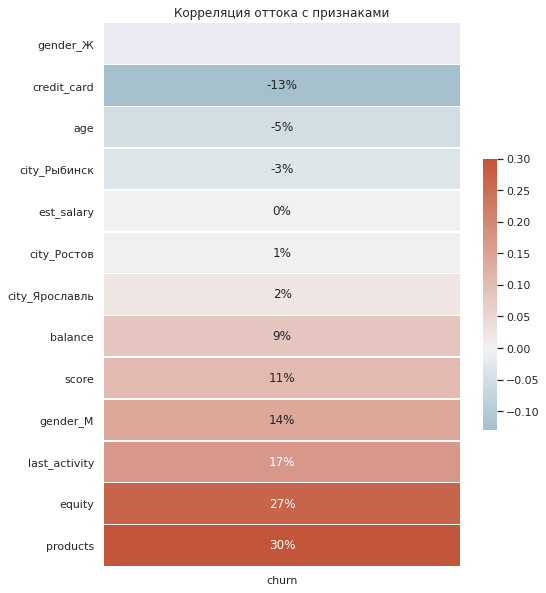

In [25]:
mask = np.triu(np.ones_like(data_dumm.corr().loc[:,['churn']].drop('churn').sort_values('churn'), dtype=bool))

f, ax = plt.subplots(figsize=(8, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
            data_dumm.corr().loc[:,['churn']].drop('churn').sort_values('churn'), 
            mask=mask, cmap=cmap, vmax=.3, center=0, annot = True, fmt='.0%', 
            linewidths=.5, cbar_kws={"shrink": .5}
            ).set_title('Корреляция оттока с признаками')
plt.show()

Корреляционный анализ подтверждает выводы по графикам выше, так имеется слабая положительная связь с products, очень слабая с  equity, last_activity, gender_M.

**Портрет клиентов в разрезе оттока.**

In [26]:
portrait = (
    data.pivot_table(index = 'churn', values = ['est_salary', 'age', 'balance', 'score'], aggfunc = 'mean')
    .join([data.pivot_table(index = 'churn', values = ['products', 'equity'], aggfunc = 'median'),
           data.groupby(['churn']).agg({'last_activity': pd.Series.mode, 'credit_card': pd.Series.mode, 'city': pd.Series.mode, 'gender': pd.Series.mode}),   
          ])).T

portrait.columns = ['Не отток', 'Отток']
portrait.index = ['Средний возраст', 'Средний баланс', 'Средний доход', 'Средний скоринг',
                    'Медианная оценка собственности', 'Медианное количество продуктов', 'Мода по активности', 
                    'Мода по количеству кредитных карт', 'Мода по городу', 'Мода по полу']

relative_diff = portrait.iloc[0:4]
relative_diff['Относительная разница, %'] = (
    abs(relative_diff['Не отток'] - relative_diff['Отток']) * 100 / relative_diff.min(axis=1)
    )

portrait = pd.concat([portrait, relative_diff['Относительная разница, %']], axis=1)
portrait['Относительная разница, %'].fillna('-', inplace=True)
portrait

,Не отток,Отток,"Относительная разница, %"
Средний возраст,43.020846,41.429593,3.840861
Средний баланс,733031.630149,1134458.209291,54.762518
Средний доход,147674.637881,148357.483157,0.462398
Средний скоринг,845.396199,863.361936,2.125126
Медианная оценка собственности,3,4,-
Медианное количество продуктов,2,2,-
Мода по активности,0,1,-
Мода по количеству кредитных карт,1,1,-
Мода по городу,Ярославль,Ярославль,-
Мода по полу,Ж,М,-


Типичный лояльный клиенты: женщина 43 лет из Ярославля, баланс около 733 тыс., доход - 147 тыс., скоринг - 845, оценка собственности - 3, количество используемых продуктов - 2, нет активности, использует 1 кредитную карту.

Типичный отточный клиент: мужчина 41 год из Ярославля, баланс около 113 тыс., доход - 148 тыс., скоринг - 863, оценка собственности - 4, количество используемых продуктов - 2, активность, использует 1 кредитную карту.

На шаге 4 (EDA) разделены и проанализированы непрерывные и дискретные признаки, построены визуализации.

Отток составляет 18%.

Отток выше лояльности в интервалах:

    баллов скоринга 820-940, 
    возраста 26-36 и 51-61, 
    баланса на счет от 1 млн., 
    уровня доходов 100 - 250 тыс.

Уровень оттока выше среднего по банку:

    в Ярославле и Рыбинске,
    среди мужчин,
    от 3 до 9 баллов собственности,
    от 3 до 5 продуктов,
    не имеющих кредитной карты,
    среди активных клиентов
    
Проведен корреляционный анализ, который подтверждает выводы  (по визуализациям). Имеется слабая положительная связь с products, очень слабая с equity, last_activity, gender_M.

Сформирован портрет клиентов банка в виде таблицы в разрезе оттока, по признакам рассчитаны меры центральной тенденции, относительная разница между ними.

## Проверка статистических гипотез

**Гипотеза о равенстве среднего дохода ушедших и оставшихся клиентов.**

H0: Средний доход ушедших и лояльных клиентов равен.

H1: Средний доход ушедших и лояльных клиентов не равен. 

Воспользоваться t-тестом, чтобы проверить гипотезу, возможно если:

    выборки не зависят друг от друга
    выборочные средние нормально распределены (с учетом размера выборок и в соответствии с ЦПТ)

Выборки не равны (разница более чем на 25%, поскольку отток составляет 18%). Проверим наличие выбросов.

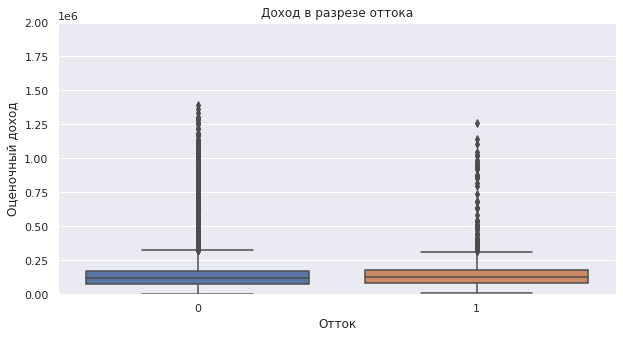

In [27]:
plt.figure(figsize=(10, 5))
(
    sns.boxplot(x='churn', y='est_salary', data=data)
    .set(title='Доход в разрезе оттока', xlabel='Отток', ylabel='Оценочный доход', ylim=(0, 2e6))
)
fig.show()

С учетом значительных выбросов (которые влияют на параметрические результаты) проведем тест Манна-Уитни.

In [28]:
alpha = 0.05

results = st.mannwhitneyu(data.query('churn == 1')['est_salary'], data.query('churn == 0')['est_salary'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение:  0.00016830729188229058
Отвергаем нулевую гипотезу


С учетом результата теста Манна-Уитни отвергаем гипотезу о равенстве среднего дохода отточных и лояльных клиентов.

**Гипотеза о равенстве среднего дохода мужчин и женщин среди отточных клиентов.**

H0: Средний доход мужчин и женщин в оттоке равен.

H1: Средний доход мужчин и женщин в оттоке не равен. 

In [29]:
print('Медианный доход мужчин:', data.query('gender == "М" & churn == 1').est_salary.mean(), '\n'
      'Медианный доход женщин:', data.query('gender == "Ж" & churn == 1').est_salary.mean())

Медианный доход мужчин: 153129.64758241756 
Медианный доход женщин: 139466.97840944884


С учетом значительных выбросов (которые влияют на параметрические результаты) проведем тест Манна-Уитни.

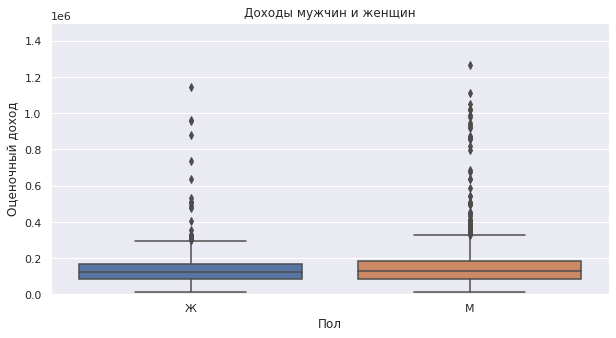

In [30]:
plt.figure(figsize=(10, 5))
(
    sns.boxplot(x='gender', y='est_salary', data=data.query('churn == 1'))
    .set(title='Доходы мужчин и женщин', xlabel='Пол', ylabel='Оценочный доход', ylim=(0, 1.5e6))
)
fig.show()

In [31]:
alpha = 0.05

results = st.mannwhitneyu(data.query('gender == "М" & churn == 1')['est_salary'], 
                          data.query('gender == "Ж" & churn == 1')['est_salary'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу о равенстве среднего дохода мужчин и женщин в оттоке') 

p-значение:  0.0934373520172292
Не получилось отвергнуть нулевую гипотезу о равенстве среднего дохода мужчин и женщин в оттоке


**Гипотеза о равенстве среднего скоринга ушедших и оставшихся клиентов.**

H0: Средний скоринг ушедших и лояльных клиентов равен.

H1: Средний скоринг ушедших и лояльных клиентов не равен. 

Явных выбросов по признаку score не имеется. Можно применить t-тест с параметром equal_var=False (поскольку выборки разного размера).

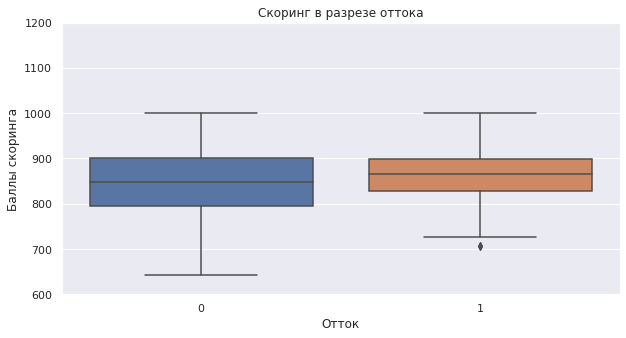

In [32]:
plt.figure(figsize=(10, 5))
(
    sns.boxplot(x='churn', y='score', data=data)
    .set(title='Скоринг в разрезе оттока', xlabel='Отток', ylabel='Баллы скоринга', ylim=(600, 1200))
)
fig.show()

In [33]:
alpha = 0.05

results = st.ttest_ind(data.query('churn == 1')['score'], 
                       data.query('churn == 0')['score'], equal_var = False)

print (results.pvalue) 

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу о равенстве среднего скоринга ушедших и оставшихся клиентов')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

1.3179430198200596e-37
Отвергаем нулевую гипотезу о равенстве среднего скоринга ушедших и оставшихся клиентов


**Гипотеза о равенстве среднего баланса ушедших и оставшихся клиентов.**

H0: Средний баланс ушедших и лояльных клиентов равен.

H1: Средний баланс ушедших и лояльных клиентов не равен.

Имеются выраженные выбросы, поэтому для проверки гипотез используем тест Манна-Уитни.

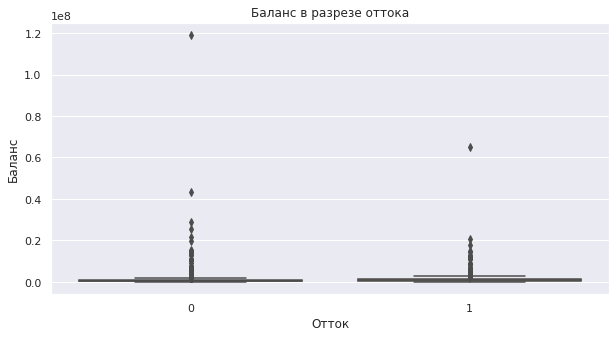

In [34]:
plt.figure(figsize=(10, 5))
(
    sns.boxplot(x='churn', y='balance', data=data)
    .set(title='Баланс в разрезе оттока', xlabel='Отток', ylabel='Баланс')
)
fig.show()

In [35]:
alpha = 0.05

results = st.mannwhitneyu(data.query('churn == 1 & ~balance.isna()')['balance'], 
                          data.query('churn == 0 & ~balance.isna()')['balance'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о равенстве среднего баланса ушедших и оставшихся клиентов')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение:  1.4891162831993242e-70
Отвергаем нулевую гипотезу о равенстве среднего баланса ушедших и оставшихся клиентов


На шаге 5 проверены статистические гипотезы о равенстве средних доходов, баллов скоринга и баланса лояльных и отточных клиентов, о равенстве средних доходов мужчин и женщин (в оттоке).

По результатам проверки отвергаем гипотезы о равенстве средних по указанным признакам лояльных и отточных клиентов. Гипотезу о равенстве средних доходов мужчин и женщин (в оттоке) отвергнуть не получилось.

## Подведение промежуточных итогов

Отток составляет 18%.

Отток выше лояльности в интервалах:

    баллов скоринга 820-940, 
    возраста 26-36 и 51-61, 
    баланса на счет от 1 млн., 
    уровня доходов 100 - 250 тыс.
    
Уровень оттока выше среднего по банку:

    в Ярославле и Рыбинске,
    среди мужчин,
    от 3 до 9 баллов собственности,
    от 3 до 5 продуктов,
    не имеющих кредитной карты,
    среди активных клиентов

Имеется слабая положительная связь оттока с products, очень слабая с equity, last_activity, gender_M.

По результатам проверки статистических гипотез отвергаем гипотезы о равенстве средних доходов, баллов скоринга и баланса лояльных и отточных клиентов, а также отвергаем гипотезу о равенстве средних доходов мужчин и женщин.

Выберем признаки, которые лягут в основу сегментации (по результатам EDA, анализа корреляции и проверки гипотез).

In [36]:
churn = data.query('churn == 1')

lst = [len(churn.query('score.between(820, 940, inclusive=True)')),
       len(churn.query('age.between(26, 36, inclusive=True)')),
       len(churn.query('age.between(51, 61, inclusive=True)')),
       len(churn.query('balance > 1e6')),
       len(churn.query('est_salary.between(1e5, 2.5e5, inclusive=True)')),
       len(churn.query('city == "Ярославль"')),
       len(churn.query('city == "Рыбинск"')),
       len(churn.query('gender == "М"')),
       len(churn.query('equity > 2')),
       len(churn.query('products > 3')),
       len(churn.query('credit_card == 0')),
       len(churn.query('last_activity == 1'))]

segment = pd.DataFrame(lst)
segment.index = ['Cкоринг 820-940', 'Возраст 26-36', 'Возраст 51-61', 'Баланс от 1 млн.', 'Доход 100 - 250 тыс.', 
                 'Ярославль', 'Рыбинск', 'Мужчины', 'Более 2 баллов equity', 'Более 3 продуктов', 
                 'Нет кредитной карты', 'Активные']
segment.columns = ['Ушедших клиентов']
segment['Доля от общего оттока, %'] = segment['Ушедших клиентов'] * 100 / len(churn)
segment.sort_values(by='Доля от общего оттока, %', ascending=False, inplace=True)
segment

,Ушедших клиентов,"Доля от общего оттока, %"
Более 2 баллов equity,1469,80.803080
Cкоринг 820-940,1374,75.577558
Активные,1277,70.242024
Мужчины,1183,65.071507
Ярославль,1117,61.441144
Доход 100 - 250 тыс.,1033,56.820682
Нет кредитной карты,815,44.829483
Баланс от 1 млн.,722,39.713971
Возраст 26-36,694,38.173817
Возраст 51-61,450,24.752475


## Сегментация

Полагаю, что целью является удержание надежных, платежеспособных клиентов, которые могут разместить крупные суммы на счетах, а также обладающих несколькими объектами недвижимости. 

Сегментируем отточных клиентов на основании следующих признаков:

    Более 820 баллов скоринга, баланс больше 1 млн.
    Доход более 100 тыс., нет кредитной карты
    Более 2 баллов собственности, баланс больше 1 млн.

Количество клиентов по сегментам, их доля в общем оттоке приведены в таблице ниже.

In [37]:
result_lst = {'Общее количество в сегменте': 
              [len(data.query('score > 820 & balance > 1e6')),
              len(data.query('est_salary > 1e5 & credit_card == 0')),
              len(data.query('equity > 2 & balance > 1e6'))],
              'Количество в оттоке':
              [len(churn.query('score > 820 & balance > 1e6')),
              len(churn.query('est_salary > 1e5 & credit_card == 0')),
              len(churn.query('equity > 2 & balance > 1e6'))]}

result = pd.DataFrame(result_lst)
result.index = ['Более 820 баллов скоринга, баланс больше 1 млн.',
                'Доход более 100 тыс., нет кредитной карты',
                'Более 2 баллов собственности, баланс больше 1 млн.']

result['Уровень оттока в сегменте, %'] = result['Количество в оттоке'] * 100 / result['Общее количество в сегменте']
result.sort_values(by='Уровень оттока в сегменте, %', ascending=False, inplace=True)
result

,Общее количество в сегменте,Количество в оттоке,"Уровень оттока в сегменте, %"
"Более 820 баллов скоринга, баланс больше 1 млн.",1513,655,43.291474
"Более 2 баллов собственности, баланс больше 1 млн.",1741,682,39.172889
"Доход более 100 тыс., нет кредитной карты",1893,561,29.635499


## Приоритизация сегментов

Предлагаю расставить приоритеты по уровню оттока в сегментах:
    
    1. Более 820 баллов скоринга, баланс больше 1 млн.	
    2. Более 2 баллов собственности, баланс больше 1 млн.	
    3. Доход более 100 тыс., нет кредитной карты		

## Формирование таргетированных рекомендаций

С учетом наполнения сегментов, признаков, которые легли в их основу можно рекомендовать (по порядке приоритета сегментов):

1. В сегменте 1 (и 2) можно предложить премиальное обслуживание, инвестиционные продукты, дополнительный процент по вкладам для "новых денег" или при выполнении условий.

2. По сегменту 2 можно предложить страховые программы в отношении недвижимости, дополнительные опции по кредитам под залог недвижимости, автокредитам, повышенный процент по вкладам (при выполнении каких-либо условий).

3. Для данной категории клиентов можно предложить дополнительные опции по кредитным картам: повышенные лимит и кэшбэк (при выполнении условий по обороту или остаткам на счетах).

**Ссылка на презентацию:** https://disk.yandex.ru/i/8uM4MkurdWMYKg

<div style="border:solid Chocolate 2px; padding: 40px">

<b> Комментарий ментора: итоговый вывод по проекту </b>

Алексей, все замечания учтены - проект принят!
    
Спасибо за хорошую работу над проектом, жду тебя на следующем этапе:)